In [1]:
import boto3
import sagemaker
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
session = boto3.session.Session()
region_name = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
database_name = "super_heroes_db"
table_name = "super_heroes_table"

Athena SQL Query using SageMaker notebook.

Get distinct publishers.

In [21]:
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
from pyathena.pandas.util import as_pandas

s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute("""
SELECT DISTINCT publisher from {0}.{1}
ORDER BY publisher
""".format(database_name, table_name))
df_categories = as_pandas(cursor)

In [26]:
df_categories.head()

,publisher
0,
1,ABC Studios
2,DC Comics
3,Dark Horse Comics
4,George Lucas


Ordering depending on hair_color 

In [44]:
cursor.execute("""
SELECT hair_color,COUNT(hair_color) from super_heroes_db.super_heroes_table 
GROUP BY hair_color ORDER BY 2 DESC
""")
results = as_pandas(cursor)

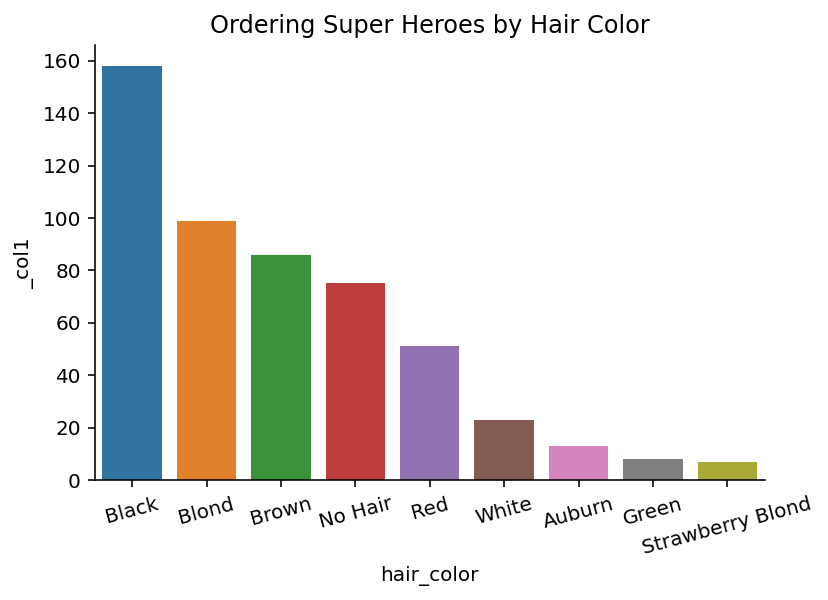

In [69]:
sns.barplot(results[1:10].hair_color, results[1:10]._col1)
plt.xticks(rotation=15)
sns.despine()
plt.title("Ordering Super Heroes by Hair Color")
plt.show()

Compare gender count

In [70]:
cursor.execute("""
SELECT gender,COUNT(gender) from super_heroes_db.super_heroes_table 
GROUP BY gender
""")
results = as_pandas(cursor)

In [83]:
results[~(results._col1==29)]

,gender,_col1
0,Male,505
2,Female,200


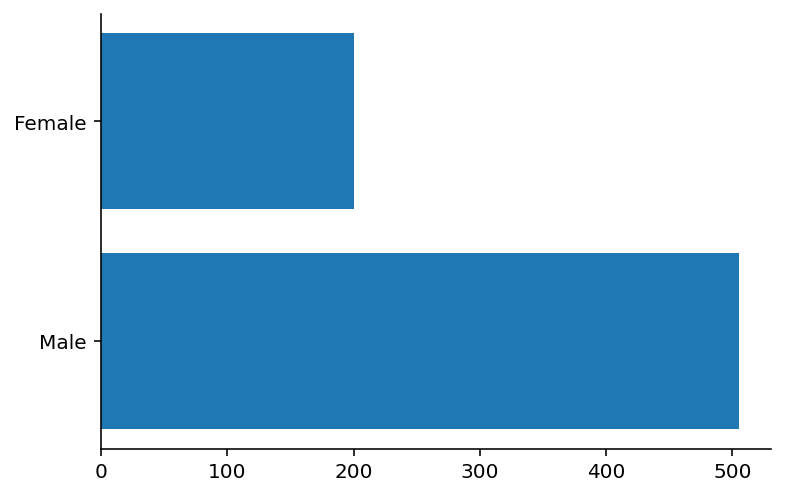

In [90]:
plt.barh(results[~(results._col1==29)]["gender"], results[~(results._col1==29)]["_col1"])
sns.despine()
plt.show()

The most common race in super heroes

In [95]:
cursor.execute("""
SELECT race,COUNT(race) from super_heroes_db.super_heroes_table 
GROUP BY race ORDER BY 2 DESC
""")
results = as_pandas(cursor)

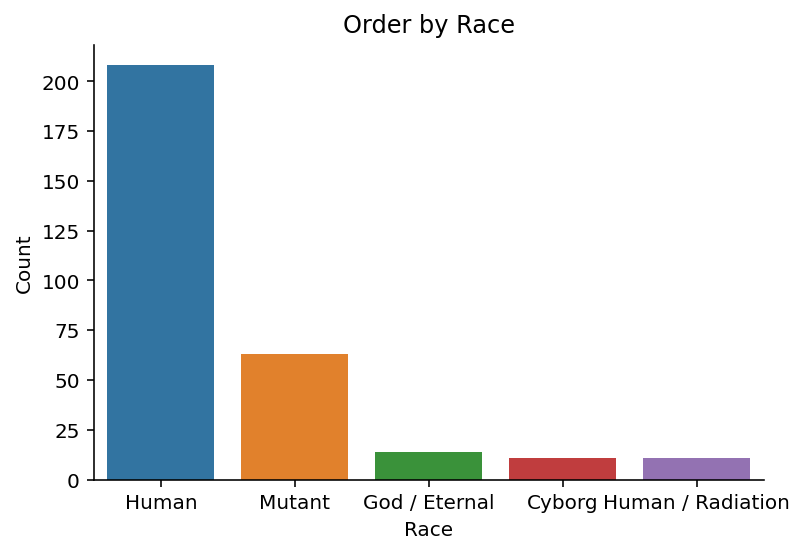

In [106]:
sns.barplot(results[1:6]["race"], results[1:6]["_col1"])
sns.despine()
plt.xlabel("Race")
plt.ylabel("Count")
plt.title("Order by Race")
plt.show()

Compare weight and height depend on gender.

In [130]:
# We need WHERE CLAUSE because there are some values under 0

cursor.execute("""
SELECT gender, AVG(height), AVG(weight) from super_heroes_db.super_heroes_table 
WHERE height>=0 AND weight>=0 GROUP BY gender
""")
results = as_pandas(cursor)

In [133]:
results.rename(columns={"_col1":"height","_col2":"weight"}, inplace=True)

In [140]:
results = results[~(results.gender=="-")]

In [141]:
results

,gender,height,weight
1,Male,192.93492,125.73433
2,Female,173.82625,78.34042


In [149]:
results.height.values, results.weight.values

(array([192.93492, 173.82625]), array([125.73433,  78.34042]))

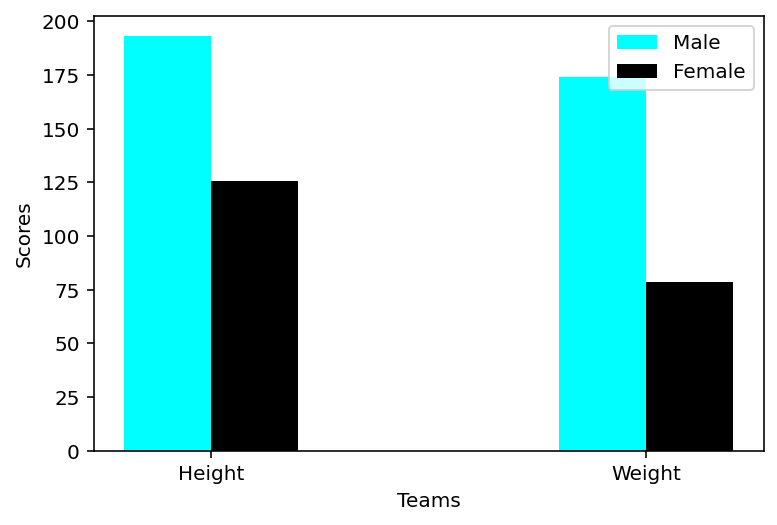

In [156]:
x = np.arange(2)
y1 = results.height.values
y2 = results.weight.values
width = 0.2

plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='black')

plt.xticks(x-0.1, ['Height', 'Weight'])
plt.xlabel("Teams")
plt.ylabel("Scores")
plt.legend(["Male", "Female"], loc="upper right")
plt.show()

___

#### Creating Dashboards with QuickSight(Data in Athena)

Watch out for permissions athena.

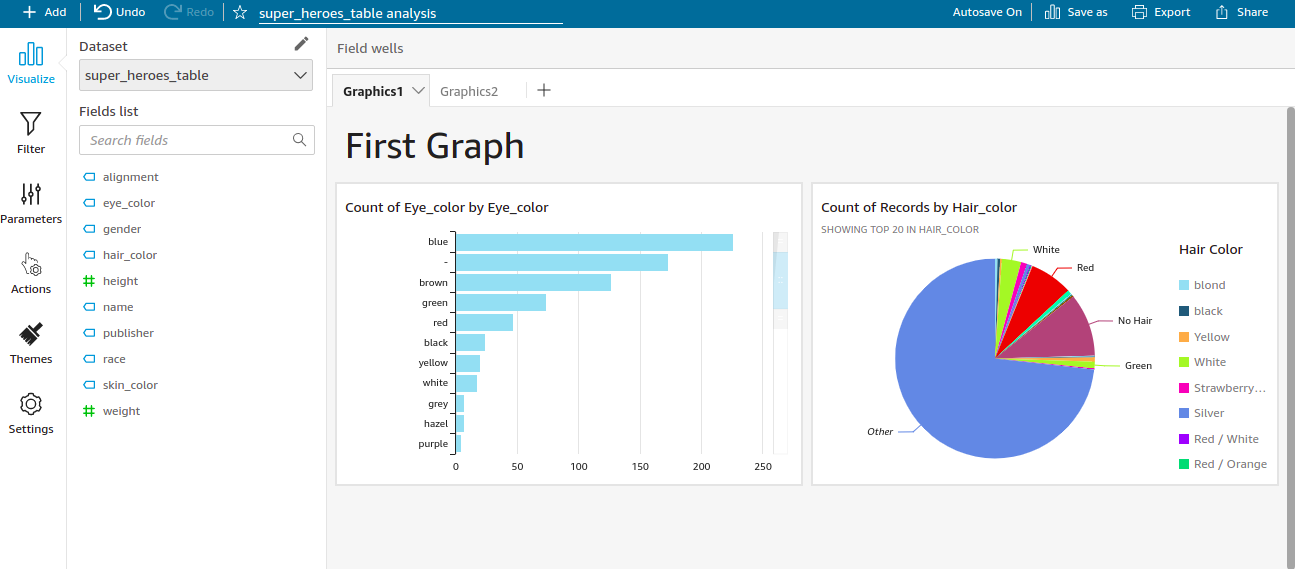

#### Analyze Data with Deequ and Apache Spark, Glue ETL 

PyDeequ, an open-source Python wrapper over Deequ, which enables you to write unit tests on your data to ensure data quality. The use case we ran through was on static, historical data, but most datasets are dynamic, so how can you quantify how your data is changing and detect anomalous changes over time?